In [1]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "drive/My Drive/train.zip"
!unzip "drive/My Drive/val.zip"
!unzip "drive/My Drive/test.zip"

Streaming output truncated to the last 5000 lines.
  inflating: test/pos/66326.jpg      
  inflating: test/pos/171447.png     
  inflating: test/pos/171153.png     
  inflating: test/pos/172639.png     
  inflating: test/pos/87071.jpg      
  inflating: test/pos/147858.jpg     
  inflating: test/pos/16323.jpg      
  inflating: test/pos/122819.jpg     
  inflating: test/pos/27074.jpg      
  inflating: test/pos/80673.jpg      
  inflating: test/pos/32418.jpg      
  inflating: test/pos/131125.jpg     
  inflating: test/pos/135658.jpg     
  inflating: test/pos/14252.jpg      
  inflating: test/pos/78996.jpg      
  inflating: test/pos/115560.jpg     
  inflating: test/pos/14667.jpg      
  inflating: test/pos/28400.jpg      
  inflating: test/pos/92392.jpg      
  inflating: test/pos/176557.png     
  inflating: test/pos/97073.jpg      
  inflating: test/pos/6768.jpg       
  inflating: test/pos/5263.jpg       
  inflating: test/pos/108570.jpg     
  inflating: test/pos/176280.png     

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
##THIS CODE IS FOR REMOVING HIDDEN FILES SO THE CLASSES ARE CORRECTTLY DETECTED IN PREPROCESSING
import os
import shutil

os.listdir("train") #First find where the ".ipynb_checkpoints" is located.

# shutil.rmtree("train/.ipynb_checkpoints") #be careful with shutil.rmtree() because it deletes every tree in that path. In other words, do not make mistakes.

['neg', 'pos']

In [4]:
# Convolutional Neural Network

# Importing the libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
tf.__version__

'2.9.2'

In [6]:
# Part 1 - Data Preprocessing

# Preprocessing the Training set
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [7]:
train_generator = train_datagen.flow_from_directory(
    'train',
    target_size= (300, 300),
    batch_size=32,
    class_mode='binary'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
     'val',
    target_size= (300, 300),
    batch_size=32,
    class_mode='binary'
)

Found 47057 images belonging to 2 classes.
Found 15685 images belonging to 2 classes.


In [8]:
# Importing Con2D and Dense, con2D is for convolutional operation and Dense is for add the nodes with respect to the hidden layers.
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,Activation,RandomFlip,RandomZoom,RandomRotation
from tensorflow.keras.regularizers import l2

In [9]:
# Part 2 - Building the CNN

# Initialising the CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout

model=Sequential()

# Data Augmentation
model.add(RandomRotation(0.1))
model.add(RandomZoom(0.1))
model.add(RandomFlip("horizontal",
                      input_shape=(300,
                                  300,
                                  3)))
# Convolution
model.add(Dropout(0.2, input_shape=(60,)))
model.add(Conv2D(64, (3,3),strides=2,padding='same', input_shape=(300, 300, 3)))
model.add(Activation('relu'))

#Pooling
model.add(MaxPool2D(pool_size=(2,2)))

# Adding second convolutional layer
model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

In [10]:
# Flattening 
from tensorflow.keras.layers import Flatten
model.add(Flatten())

#Full connection
model.add(Dense(128))
model.add(Activation('relu'))

#Output layer
# Using activation function as linear, because for binary classification we use linear svm.Linear svm means we try to draw a line between the particular classes.
model.add(Dense(1,kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='linear'))

In [11]:
model.compile (
    loss = 'hinge',
    optimizer = 'adam',
    metrics=['accuracy']
)

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
result=model.fit(x=train_generator, validation_data=test_generator,epochs=10)

Epoch 1/10
 658/1471 [============>.................] - ETA: 41:42 - loss: 0.4277 - accuracy: 0.8211

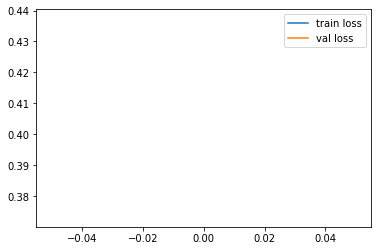

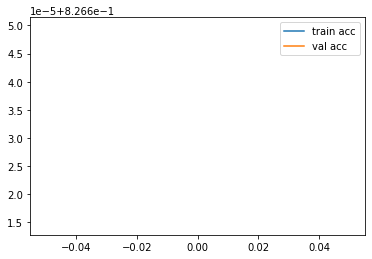

In [ ]:
import matplotlib.pyplot as plt
plt.plot(result.history['loss'],label='train loss')
plt.plot(result.history['val_loss'],label='val loss')
plt.legend()
plt.show()
plt.savefig('Loss_val loss')

plt.plot(result.history['accuracy'],label='train acc')
plt.plot(result.history['val_accuracy'],label='val acc')
plt.legend()
plt.savefig('accVal_acc')

In [ ]:
from tensorflow.keras.models import load_model

model.save('cnn_svm.h5')

In [ ]:
import numpy as np
img = tf.keras.utils.load_img(
    'test/pos/100001.jpg', target_size=(300, 300)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
class_names = np.array(list(train_generator.class_indices.keys()))
print(class_names)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

['.ipynb_checkpoints' 'ad' 'nonAd']
1/1 [==============================] - 0s 55ms/step
This image most likely belongs to .ipynb_checkpoints with a 100.00 percent confidence.


In [ ]:
from keras.models import load_model
from PIL import Image

Image.MAX_IMAGE_PIXELS = None

# Flow test images in batches of 20 using test_datagen generator
test_gen = ImageDataGenerator( rescale = 1.0/255. )
test_generator = test_gen.flow_from_directory( 'test',  batch_size = 20, class_mode = 'binary', target_size = (300, 300))

# Evaluate on test data
scores = model.evaluate(test_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

Found 15687 images belonging to 2 classes.
785/785 [==============================] - 275s 351ms/step - loss: 0.4381 - accuracy: 0.8266
evaluate accuracy: 82.66%


In [ ]:
from sklearn.metrics import confusion_matrix

# y_pred = saved_model.predict(test_generator)
y_pred = model.predict(test_generator)

785/785 [==============================] - 272s 346ms/step


In [ ]:
import numpy as np
y_pred = np.rint(y_pred)
print(confusion_matrix(test_generator.classes, y_pred))
print(test_generator.classes)
print(test_generator.class_indices.keys())
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, y_pred))

[[    0  2720]
 [    0 12967]]
[0 0 0 ... 1 1 1]
dict_keys(['neg', 'pos'])
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2720
           1       0.83      1.00      0.91     12967

    accuracy                           0.83     15687
   macro avg       0.41      0.50      0.45     15687
weighted avg       0.68      0.83      0.75     15687



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
